In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [26]:
source_df = pd.read_excel(r'C:\Users\user\Desktop\대구빅데WS\final data.xlsx', index_col=0)

In [27]:
source_df

,"Crude oil, Dubai","Coal, Australian","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",U$/MT,ChatGPT_Score
Month,,,,,,,
2013-10-01,106.302273,79.4125,3.6739,11.370000,15.300000,752.368022,-2
2013-11-01,105.853810,82.2500,3.6174,11.420000,15.400000,757.827849,-2
2013-12-01,107.919524,84.3375,4.2366,11.550000,16.380000,761.290646,-1
2014-01-01,104.010000,81.6100,4.7008,11.590000,16.670000,810.300120,-4
2014-02-01,104.940000,76.2900,5.9733,11.300000,16.760000,861.274592,-5
...,...,...,...,...,...,...,...
2022-04-01,102.680000,310.8500,6.5306,32.204187,16.287524,695.031958,-14
2022-05-01,108.320000,371.8600,8.1373,29.170723,16.679091,723.310581,-8
2022-06-01,115.730000,374.0800,7.6740,33.557731,15.533921,762.065675,-9


In [28]:
# 종속변수와 독립변수 나누기
independent_list = ['Crude oil, Dubai', 'Coal, Australian','Natural gas, US','Natural gas, Europe','Liquefied natural gas, Japan','ChatGPT_Score']
dependent_list = ['U$/MT']

# 데이터 스케일링 (0과 1 사이의 값으로 변환)
#scaler = MinMaxScaler()
#scaled_data = scaler.fit_transform(source_df)

# 데이터 전처리
X = source_df[independent_list]
y = source_df[dependent_list]
def create_dataset(data, X, y, source_len, time_steps):
    Xs, ys = [], []
    for i in range(len(data) - source_len - time_steps + 1):
        Xs.append(X.iloc[i:i+source_len, :-1])
        ys.append(y.iloc[i + source_len + time_steps - 1, -1])
    return np.array(Xs), np.array(ys)

source_len = 70
time_steps = 1

Xs, ys = create_dataset(source_df, X, y, source_len, time_steps)
type(Xs), type(ys)

(numpy.ndarray, numpy.ndarray)

In [29]:

# Train-test 분리
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

#X_train = X_train.astype(float)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

num_samples, time_steps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(num_samples, time_steps * num_features)
num_samples, time_steps, num_features = X_test.shape
X_test_reshaped = X_test.reshape(num_samples, time_steps * num_features)

X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_test_scaled = scaler_X.transform(X_test_reshaped)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [30]:

# X_train_scaled의 형태를 확인
print("X_train_scaled shape:", X_test_scaled.shape)

# X_train_scaled의 형태 수정
num_samples, num_time_steps = X_train_scaled.shape
num_time_steps = source_len
num_features = len(independent_list)-1

X_train_scaled = X_train_scaled.reshape(num_samples, num_time_steps, num_features)

# X_test_scaled의 형태 수정
num_samples, num_time_steps = X_test_scaled.shape
num_time_steps = source_len
num_features = len(independent_list)-1
X_test_scaled = X_test_scaled.reshape(num_samples, num_time_steps, num_features)
X_train_scaled, X_test_scaled 

X_train_scaled shape: (8, 350)


(array([[[0.24132823, 0.11598052, 0.13804816, 0.27009728, 0.36905054],
         [0.16201758, 0.0413845 , 0.0879764 , 0.20712122, 0.30858856],
         [0.        , 0.0349345 , 0.05176046, 0.15398574, 0.2585773 ],
         ...,
         [0.47540071, 0.17686187, 0.1801284 , 0.17966649, 0.27285937],
         [0.51579061, 0.24643452, 0.26710882, 0.21377646, 0.33588638],
         [0.55353963, 0.28636208, 0.33578052, 0.21977303, 0.34433892]],
 
        [[0.35588199, 0.44333776, 0.31715765, 0.56439715, 0.76289392],
         [0.32365304, 0.27257336, 0.25725723, 0.56769819, 0.64369904],
         [0.32850521, 0.12755688, 0.20554359, 0.37295998, 0.43780375],
         ...,
         [0.19846394, 0.01386299, 0.02864685, 0.05823376, 0.        ],
         [0.17769846, 0.02549855, 0.10468224, 0.08120048, 0.02658153],
         [0.21493767, 0.03661875, 0.14948272, 0.06553478, 0.0747607 ]],
 
        [[1.        , 0.49712262, 0.89605192, 0.76120567, 0.94808245],
         [0.97134123, 0.3476298 , 0.5403595

In [31]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=140, verbose=1)


Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0211
Epoch 2/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0198
Epoch 3/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0187
Epoch 4/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0178
Epoch 5/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0170
Epoch 6/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0164
Epoch 7/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0160
Epoch 8/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0156
Epoch 9/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0152
Epoch 10/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0149
Epoch 11/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0146
Epoch 12/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0144
Epoch 13/1000
1/1 [====================

In [32]:
def calculate_r2_adj(y_true, y_pred, n_features):
    """
    Calculate adjusted R-squared (R2(adj)).

    Parameters:
        y_true (array-like): 실제값들을 담은 배열 또는 리스트
        y_pred (array-like): 예측값들을 담은 배열 또는 리스트
        n_features (int): 독립 변수의 수

    Returns:
        float: R2(adj) 값
    """
    assert len(y_true) == len(y_pred), "실제값과 예측값의 길이가 동일해야 합니다."

    # R-squared 계산
    total_sum_of_squares = sum((true_val - np.mean(y_true))**2 for true_val in y_true)
    residual_sum_of_squares = sum((true_val - pred_val)**2 for true_val, pred_val in zip(y_true, y_pred))
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)

    # R2(adj) 계산
    n = len(y_true)
    r2_adj = 1 - (1 - r_squared) * (n - 1) / (n - n_features - 1)

    return r2_adj


In [33]:

# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test_scaled)
y_pred

1/1 [==============================] - 0s 130ms/step


array([[0.08101106],
       [0.0607153 ],
       [0.2070747 ],
       [0.76758623],
       [0.6025739 ],
       [0.38106838],
       [0.18736881],
       [0.4618784 ]], dtype=float32)

In [34]:

# 스케일링 복원
y_test_predicted = scaler_y.inverse_transform(y_pred)
y_test_predicted

array([[350.56985],
       [331.83664],
       [466.92798],
       [984.2864 ],
       [831.9781 ],
       [627.52606],
       [448.73926],
       [702.1146 ]], dtype=float32)

In [35]:

# MAPE 계산
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mape(y_test, y_test_predicted)
print('Test MAPE:', test_mape)

test_r2 = calculate_r2_adj(y_test, y_test_predicted, len(independent_list))
print('R2(adj): ', test_r2)


Test MAPE: 11.497629700755502
R2(adj):  [0.19578156]


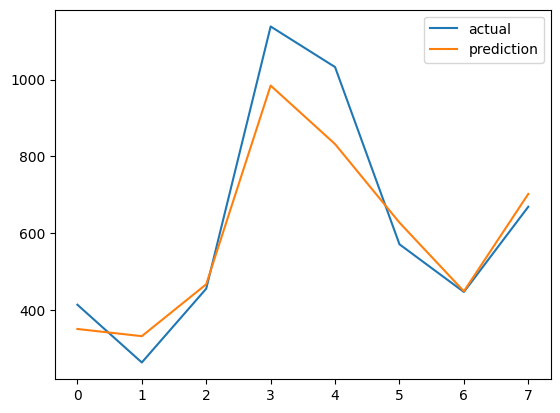

In [36]:
import matplotlib.pyplot as plt
#test_mape = mape(y_test_actual, y_test_predicted)
plt.plot(y_test, label='actual')
plt.plot(y_test_predicted, label='prediction')
plt.legend()
plt.show()
     

In [37]:
# 전체로 예측 수행
num_samples, time_steps, num_features = Xs.shape
Xs_reshaped = Xs.reshape(num_samples, time_steps * num_features)
Xs_scaled = scaler_X.fit_transform(Xs_reshaped)

num_samples, num_time_steps = Xs_scaled.shape
num_time_steps = source_len
num_features = len(independent_list)-1
Xs_scaled = Xs_scaled.reshape(num_samples, num_time_steps, num_features)
#ys_rehsaped = ys.reshape(-1, 1)
#temp = scaler_y.fit_transform(ys_rehsaped)

ys_pred = model.predict(Xs_scaled)
ys_predicted = scaler_y.inverse_transform(ys_pred)


2/2 [==============================] - 0s 5ms/step


In [47]:

# MAPE 계산
def mape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true)*100

test_mape = mape(ys, ys_predicted)
print('Test MAPE:', test_mape)

test_r2 = calculate_r2_adj(ys, ys_predicted, len(independent_list))
print('R2(adj): ', test_r2)


Test MAPE: 43.06907233172218
R2(adj):  [0.9083593]


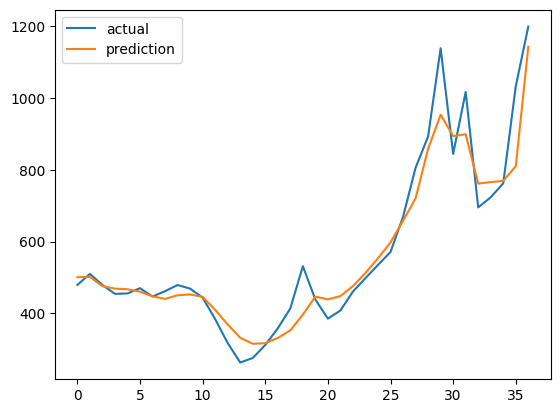

In [39]:
plt.plot(ys, label='actual')
plt.plot(ys_predicted, label='prediction')
plt.legend()
plt.show()